# Lending Club Preprocessing / Training Part 1

In [22]:
import numpy as np
import pandas as pd
import pickle
import datetime

import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler, SMOTE

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix, classification_report

import warnings
warnings.filterwarnings(action = 'ignore')

In [23]:
with open('lending_club_missingvals_pick.pkl', 'rb') as pickle_file:
    data = pickle.load(pickle_file)

In [24]:
data.shape

(2260668, 108)

In [25]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)
#pd.reset_option('display.float_format')
pd.set_option('display.max_columns', None)

# Visualizing Distribution of Data Types

Text(0, 0.5, 'Data type')

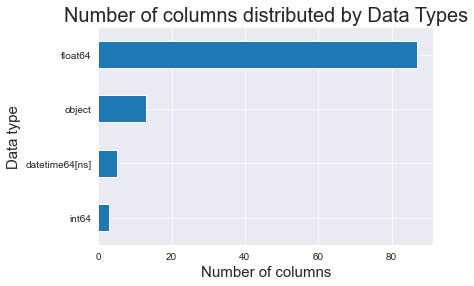

In [26]:
data.dtypes.value_counts().sort_values().plot(kind='barh')
plt.title('Number of columns distributed by Data Types',fontsize=20)
plt.xlabel('Number of columns',fontsize=15)
plt.ylabel('Data type',fontsize=15)

In [27]:
allobjects = data.dtypes[data.dtypes == 'O'].index
allfloats = data.dtypes[data.dtypes == 'float'].index
allints = data.dtypes[data.dtypes == 'int64'].index
data.loc[:, allobjects]

,grade,sub_grade,home_ownership,verification_status,loan_status,pymnt_plan,purpose,addr_state,initial_list_status,application_type,hardship_flag,disbursement_method,debt_settlement_flag
0,C,C4,MORTGAGE,Not Verified,Fully Paid,n,debt_consolidation,PA,w,Individual,N,Cash,N
1,C,C1,MORTGAGE,Not Verified,Fully Paid,n,small_business,SD,w,Individual,N,Cash,N
2,B,B4,MORTGAGE,Not Verified,Fully Paid,n,home_improvement,IL,w,Joint App,N,Cash,N
3,C,C5,MORTGAGE,Source Verified,Current,n,debt_consolidation,NJ,w,Individual,N,Cash,N
4,F,F1,MORTGAGE,Source Verified,Fully Paid,n,major_purchase,PA,w,Individual,N,Cash,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2260694,C,C1,MORTGAGE,Source Verified,Current,n,home_improvement,AL,f,Individual,N,Cash,N
2260695,B,B3,MORTGAGE,Not Verified,Current,n,debt_consolidation,UT,f,Individual,N,Cash,N
2260696,B,B3,MORTGAGE,Verified,Current,n,debt_consolidation,CA,f,Individual,N,Cash,N
2260697,C,C4,RENT,Not Verified,Charged Off,n,debt_consolidation,FL,f,Individual,N,Cash,Y


In [28]:
data.loc[:, allfloats]

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,3600.00000,3600.00000,3600.00000,13.99000,123.03000,55000.00000,5.91000,0.00000,675.00000,679.00000,1.00000,30.00000,72.31284,7.00000,0.00000,2765.00000,29.70000,13.00000,0.00000,0.00000,4421.72392,4421.72000,3600.00000,821.72000,0.00000,0.00000,0.00000,122.67000,564.00000,560.00000,0.00000,30.00000,0.00000,722.00000,144904.00000,2.00000,2.00000,0.00000,1.00000,21.00000,4981.00000,36.00000,3.00000,3.00000,722.00000,34.00000,9300.00000,3.00000,1.00000,4.00000,4.00000,20701.00000,1506.00000,37.20000,0.00000,0.00000,148.00000,128.00000,3.00000,3.00000,1.00000,4.00000,69.00000,4.00000,69.00000,2.00000,2.00000,4.00000,2.00000,5.00000,3.00000,4.00000,9.00000,4.00000,7.00000,0.00000,0.00000,0.00000,3.00000,76.90000,0.00000,0.00000,0.00000,178050.00000,7746.00000,2400.00000,13734.00000
1,24700.00000,24700.00000,24700.00000,11.99000,820.28000,65000.00000,16.06000,1.00000,715.00000,719.00000,4.00000,6.00000,72.31284,22.00000,0.00000,21470.00000,19.20000,38.00000,0.00000,0.00000,25679.66000,25679.66000,24700.00000,979.66000,0.00000,0.00000,0.00000,926.35000,699.00000,695.00000,0.00000,44.16422,0.00000,0.00000,204396.00000,1.00000,1.00000,0.00000,1.00000,19.00000,18005.00000,73.00000,2.00000,3.00000,6472.00000,29.00000,111800.00000,0.00000,0.00000,6.00000,4.00000,9733.00000,57830.00000,27.10000,0.00000,0.00000,113.00000,192.00000,2.00000,2.00000,4.00000,2.00000,37.00000,0.00000,6.00000,0.00000,5.00000,5.00000,13.00000,17.00000,6.00000,20.00000,27.00000,5.00000,22.00000,0.00000,0.00000,0.00000,2.00000,97.40000,7.70000,0.00000,0.00000,314017.00000,39475.00000,79300.00000,24667.00000
2,20000.00000,20000.00000,20000.00000,10.78000,432.66000,63000.00000,10.78000,0.00000,695.00000,699.00000,0.00000,34.54092,72.31284,6.00000,0.00000,7869.00000,56.20000,18.00000,0.00000,0.00000,22705.92429,22705.92000,20000.00000,2705.92000,0.00000,0.00000,0.00000,15813.30000,704.00000,700.00000,0.00000,44.16422,0.00000,0.00000,189699.00000,0.00000,1.00000,0.00000,4.00000,19.00000,10827.00000,73.00000,0.00000,2.00000,2081.00000,65.00000,14000.00000,2.00000,5.00000,1.00000,6.00000,31617.00000,2737.00000,55.90000,0.00000,0.00000,125.00000,184.00000,14.00000,14.00000,5.00000,101.00000,37.00000,10.00000,0.00000,0.00000,2.00000,3.00000,2.00000,4.00000,6.00000,4.00000,7.00000,3.00000,6.00000,0.00000,0.00000,0.00000,0.00000,100.00000,50.00000,0.00000,0.00000,218418.00000,18696.00000,6200.00000,14877.00000
3,35000.00000,35000.00000,35000.00000,14.85000,829.90000,110000.00000,17.06000,0.00000,785.00000,789.00000,0.00000,34.54092,72.31284,13.00000,0.00000,7802.00000,11.60000,17.00000,15897.65000,15897.65000,31464.01000,31464.01000,19102.35000,12361.66000,0.00000,0.00000,0.0

In [29]:
data.loc[:, allints]

,term,emp_length,TARGET
0,36,10,0
1,36,10,0
2,60,10,0
3,60,10,0
4,60,3,0
...,...,...,...
2260694,60,7,0
2260695,60,10,0
2260696,60,9,0
2260697,60,6,0


In [30]:
o_ordered_subset = ['grade', 'sub_grade', 'emp_length', 'loan_status']
o_unordered_subset = ['home_ownership', 'verification_status', 'loan_status', 'purpose', 'addr_state']
label_encoded = ['term', 'pymnt_plan', 'initial_list_status', 'application_type', 'hardship_flag', 'disbursement_method', 'debt_settlement_flag']

Setting up correct promotion types for StandardScaler. Not doing this will output an Invalid Promotion Type error for Date Time formats.

Considering dropping time columns, purpose of the model is to predict likely for loan default based on features, we might want this to be time invariant. Time maybe spot trends over years.

In [49]:
for col in data.dtypes[data.dtypes == '<M8[ns]'].index:
    data[col] = (data.loc[:, col] - pd.to_datetime('1970-01-01')).astype('int64') / 1e9 / 60 / 60 / 24

In [50]:
data.reset_index(drop = True, inplace = True)

In [77]:
def preprocess_inputs(df):
    df = df.copy()
    
    #label encode
    df = label_encode(df)
    
    #Binary Encode
    df = dummy_encoding(df)
    
    #split into x and y
    y = df['TARGET']
    X = df.drop('TARGET', axis = 1)
    
    #Train Test Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 1)
    
    #Scale X
    sc = StandardScaler()
    sc.fit(X_train)
    X_train = pd.DataFrame(sc.transform(X_train), index = X_train.index, columns = X_train.columns)
    X_test = pd.DataFrame(sc.transform(X_test), index = X_test.index, columns = X_test.columns)
    
    
    return X_train, X_test, y_train, y_test

# Examining Class Imbalance

In [78]:
X_train, X_test, y_train, y_test = preprocess_inputs(data)

In [79]:
y_train.value_counts()

0    1808505
1         29
Name: TARGET, dtype: int64

In [80]:
fig = px.pie(
    y_train.value_counts(),
    values = 'TARGET',
    names = ['non_default', 'default'],
    title = 'Class Distribution',
    width = 500
)
fig.show()

# Training a Model (Imbalanced Classes)

In [81]:
def evaluate_model(model, X_test, y_test):
    
    acc = model.score(X_test, y_test)
    print("Accuracy: {:.2f}%".format(acc * 100))
    
    y_pred = model.predict(X_test)
    
    cm = confusion_matrix(y_test, y_pred, labels=['non_default', 'default'])
    clr = classification_report(y_test, y_pred, labels=['non_default', 'default'])
    
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
    plt.xticks(ticks=[0.5, 1.5], labels=['non_default', 'default'])
    plt.yticks(ticks=[0.5, 1.5], labels=['non_default', 'default'])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()
    
    print("Classification Report:\n----------------------\n", clr)

In [82]:
model = LogisticRegression()
model.fit(X_train, y_train)

evaluate_model(model, X_test, y_test)

Accuracy: 100.00%


ValueError: At least one label specified must be in y_true

# Label Encoding and One Hot Encoding:

Label Encoding will give categories an arbitrary ordering so it only makes sense with categories that have 2 unique values for example, yes and no. With categorical values that have 2 or more unique values one hot encoding is the better option. 

The question here is whether or not I am going to split into train/test, or just look at training accuracy. If I'm planning on splitting, I want to do so before imputing the data, to avoid leaking any info from the test set into the model. But since this data has already be imputed it might be interesting to compare the results.

In [40]:
#Label Encoding
def label_encode(df):
    count = 0

    for col in df:
        if df[col].dtype == 'object':
            if len(list(df[col].unique())) <= 2:     
                le = preprocessing.LabelEncoder()
                df[col] = le.fit_transform(df[col])
                count += 1

    return df

In [59]:
#One Hot Encoding
def dummy_encoding(df):
    df = pd.get_dummies(df)
    
    return df

# Conducting Train Test Split:

Here I am normalizing or standarizing the data so it has a mean of 0 and a standard deviation of 1

In [56]:
def scaling_data(df):
    sc = StandardScaler()
    sc.fit(X_train)
    X_train = pd.DataFrame(sc.transform(X_train), index = X_train.index, columns = X_train.columns)
    X_test = pd.DataFrame(sc.transform(X_test), index = X_test.index, columns = X_test.columns)
    
    return df

# Oversampling the Training Set using SMOTE:

In [15]:
from imblearn.over_sampling import SMOTE

In [16]:
sm = SMOTE(random_state=12, sampling_strategy = 1.0)
x_train_r, y_train_r = sm.fit_resample(X_train, y_train)

In [17]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(C = 0.0001,random_state=21)

log_reg.fit(x_train_r, y_train_r)

LogisticRegression(C=0.0001, random_state=21)

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix